## Importing libraries

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
import matplotlib.pyplot as plt
from PIL import Image  # Import PIL to resize images
import shutil

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter

In [3]:
seed = 42
np.random.seed(seed)

Clear the contents of the working directory to save our data after splitting. 

In [23]:
# Set the path to the Kaggle working directory
working_dir = r'..\data\working'

# Delete all files and subdirectories in the working directory
for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    if os.path.isfile(item_path):
        os.remove(item_path)
    elif os.path.isdir(item_path):
        shutil.rmtree(item_path)

# Confirm that the directory is empty
print("Working directory has been cleared.")


Working directory has been cleared.


## Defining Tranformation and Augmentation function

Transformation and augmentation are techniques commonly used in machine learning and computer vision, especially in the context of training deep learning models, including neural networks. These techniques are primarily applied to manipulate and enhance the training data to improve the model's performance, generalization, and robustness.

Image Transformation: In computer vision, image transformation refers to operations that alter the appearance of an image without changing its semantic content. Common image transformations include resizing, cropping, rotation, flipping, and color adjustments.

Data Augmentation: Data augmentation is a technique used to artificially increase the diversity of the training dataset by applying various transformations to the existing data. In computer vision, this often involves generating new training samples by randomly applying operations like rotation, translation, scaling, shearing, flipping, and introducing random noise to the images. Augmentation helps the model generalize better to unseen data and reduces overfitting.

The primary goal of both transformation and augmentation is to make the model more resilient to variations and noise in the input data, ultimately improving its ability to make accurate predictions on real-world, unseen data. These techniques are particularly important in deep learning, where models have a large number of parameters and can easily overfit to the training data if not exposed to diverse examples.

We will also be applying extra augmentation to our minority classes in the train dataset to balance out training dataset so our model can generalize better.

In [5]:

# Define the minority classes in your dataset
class_names = ['malignant', 'normal','benign']
minority_classes = ['malignant', 'normal']

# Define custom data transformations for minority classes
minority_class_transforms = transforms.Compose([
    RandomHorizontalFlip(p=0.9),  # Apply with 90% probability
    RandomRotation(15, expand=False, center=None),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

# Define data transformations for train, validation, and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # Apply custom augmentations to minority classes
        transforms.RandomApply([minority_class_transforms], p=0.5) if any(cls in minority_classes for cls in class_names) else transforms.RandomApply([], p=0.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Approach 1 - Data Split and create folders- excludes mask files

In [ ]:
# Set the path to your input folder
data_dir = r'..\data\original'

# Define the paths for the train, validation, and test directories
train_dir = r'..\data\working\train'
val_dir = r'..\data\working\validation'
test_dir = r'..\data\working\test'

# Create a list to store file paths and labels
file_paths = []
labels = []

# Loop through the subdirectories (benign, malignant, normal)
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            if image_file.endswith('.png') and not (image_file.endswith('_mask.png') or 
                                                     image_file.endswith('_mask_1.png') or
                                                     image_file.endswith('_mask_2.png')):
                image_path = os.path.join(label_dir, image_file)
                labels.append(label)
                file_paths.append(image_path)

# Create a DataFrame to store the file paths and labels
data = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

# Split the dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=seed, stratify=data['Label'])
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=seed, stratify=train_data['Label'])



# Create the train, validation, and test directories and subdirectories
for label in labels:
	os.makedirs(os.path.join(train_dir, label), exist_ok=True)
	os.makedirs(os.path.join(test_dir, label), exist_ok=True)
	os.makedirs(os.path.join(val_dir, label), exist_ok=True)

# List of tuples containing data and corresponding directories
data_dirs = [(train_data, train_dir), (test_data, test_dir), (val_data, val_dir)]

# Copy the images to the respective directories
for data, directory in data_dirs:
	for _, row in data.iterrows():
		image_path = row['Image_Path']
		label = row['Label']
		shutil.copy(image_path, os.path.join(directory, label))




Get the label counts after split - excludes mask files

In [7]:
dirs = [train_dir, test_dir, val_dir]
subdirs = ['benign', 'malignant', 'normal']

dir_names = ['train', 'test', 'validation']

for i, dir in enumerate(dirs):
	file_counts = {}
	for subdirectory in subdirs:
		subdirectory_path = os.path.join(dir, subdirectory)
		if os.path.exists(subdirectory_path):
			file_count = len(os.listdir(subdirectory_path))
			file_counts[subdirectory] = file_count

	for category, count in file_counts.items():
		print(f"{dir_names[i]} {category}: {count}")



train benign: 280
train malignant: 134
train normal: 85
test benign: 87
test malignant: 42
test normal: 27
validation benign: 70
validation malignant: 34
validation normal: 21


Apply transfromation and augmentation to the datasets. Augmentation is only applied to the training data with extra focus on minority classes to balance the dataset. Calling the function that was defined earlier in the notebook.

In [9]:
data_dir=r'..\data\working'

# Create datasets for train, validation, and test
image_datasets = {
    x: ImageFolder(
        root=os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in ['train', 'validation', 'test']
}

# Specify batch size for dataloaders
batch_size = 8  # You can adjust this based on your hardware and preferences

# Create dataloaders for train, validation, and test
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=8)
               for x in ['train', 'validation', 'test']}

# Calculate dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

# Get class labels
class_names = image_datasets['train'].classes

# Print dataset sizes and class labels
print("Dataset Sizes:", dataset_sizes)
print("Class Labels:", class_names)

Dataset Sizes: {'train': 499, 'validation': 125, 'test': 156}
Class Labels: ['benign', 'malignant', 'normal']


## Define training function - To be used for both approaches

Adding early stop to avoid extra processing time. Tranining will stop if validation loss doesn't improve for 2 consecutive epochs.

In [11]:
# Define the training function with early stopping and additional features
def train_model_with_early_stopping(model, lossFunction, optimizer, scheduler, dataloaders, dataset_sizes, class_names, device, num_epochs=20, patience=2):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')  # Initialize best_loss with a large value
    consecutive_epochs_without_improvement = 0

    # Lists to store training and validation losses
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = lossFunction(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Append training loss here
                if phase == 'train':
                    train_losses.append(loss.item())  # Append training loss
                else:
                    val_losses.append(loss.item())  # Append validation loss

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Early stopping: Check if validation loss improved
            if phase == 'validation':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    consecutive_epochs_without_improvement = 0
                else:
                    consecutive_epochs_without_improvement += 1


                val_losses.append(epoch_loss)

        # Check if early stopping criteria are met
        if consecutive_epochs_without_improvement >= patience:
            print(f"Early stopping after {epoch} epochs")
            break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:.4f}'.format(best_loss))
   
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    # Calculate classification report and confusion matrix for validation data
    y_true = []
    y_pred = []

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for inputs, labels in dataloaders['validation']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Generate classification report
    target_names = [str(class_names[i]) for i in range(len(class_names))]
    print(classification_report(y_true, y_pred, target_names=target_names))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    return model

Point to GPU if exists

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


NVIDIA GeForce RTX 3060 Laptop GPU


## Approach 1 -Model Set up/Initialize

We wil use a pre trained resnet model and train out model. This approach is called transfer learning where the model can transfer its existing knowledge on a mmore customized dataset

In [17]:
#Transfer Learning by fineTuning the pretrained Resnet101 Model
#Load Resnet101 pretained Model
#Resnet101 = models.resnet101(pretrained=True)
#If pretained is not working, you can also use weights instead.
Resnet101 = models.resnet101(weights=True)

print(Resnet101)
#Set the resnet param.requires_grad = True to calculate the gradient,
#so that model fine-tunes the weights of the pretrained network
#by continuing the backpropagation.
for param in Resnet101.parameters():
    param.requires_grad = True

#Get the number of Input features of Resnet last fully connected layer
#because we are going to replace it with new fully connected layer.
in_features = Resnet101.fc.in_features

#Reset the final fully connected layer of the of the pre-trained Resnet.
Resnet101.fc = nn.Linear(in_features, len(class_names))

Resnet_fineTuning = Resnet101.to(device)

C:\Users\Erik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Defining optimizer, hyperparameters and loss function

In [18]:
#Define optimzation algorithm
optimizer = optim.Adam(Resnet_fineTuning.parameters(), lr=0.00005)

# Decay LR by a factor of 0.1 every 7 epochs
Decay_Learning_Rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#Define loss functions
Loss_Function = nn.CrossEntropyLoss()

## Approach 1 - Fine Tuning and training

In [20]:
model_fineTuning = train_model_with_early_stopping(
    Resnet_fineTuning, Loss_Function, optimizer, Decay_Learning_Rate, 
    dataloaders, dataset_sizes, class_names, device,num_epochs=20, patience=2)
torch.save(model_fineTuning, r"..\data\working\Resnet_fineTuning.pth")

Epoch 0/19
----------
train Loss: 0.2823 Acc: 0.8878
validation Loss: 0.5385 Acc: 0.8640

Epoch 1/19
----------
train Loss: 0.2423 Acc: 0.9259
validation Loss: 0.4083 Acc: 0.8880

Epoch 2/19
----------
train Loss: 0.2575 Acc: 0.9058
validation Loss: 0.3646 Acc: 0.8960

Epoch 3/19
----------
train Loss: 0.1626 Acc: 0.9559
validation Loss: 0.3839 Acc: 0.9040

Epoch 4/19
----------
train Loss: 0.1436 Acc: 0.9579
validation Loss: 0.3635 Acc: 0.9040

Epoch 5/19
----------
train Loss: 0.1208 Acc: 0.9639
validation Loss: 0.3459 Acc: 0.9120

Epoch 6/19
----------
train Loss: 0.1219 Acc: 0.9639
validation Loss: 0.3482 Acc: 0.8880

Epoch 7/19
----------
train Loss: 0.1471 Acc: 0.9559
validation Loss: 0.3550 Acc: 0.8880
Early stopping after 7 epochs
Training complete in 3m 2s
Best val Loss: 0.3459
              precision    recall  f1-score   support

      benign       0.93      0.94      0.94        70
   malignant       0.93      0.79      0.86        34
      normal       0.84      1.00      

## Approach 1 -  Model Evaluation - Using ultrasound image files only

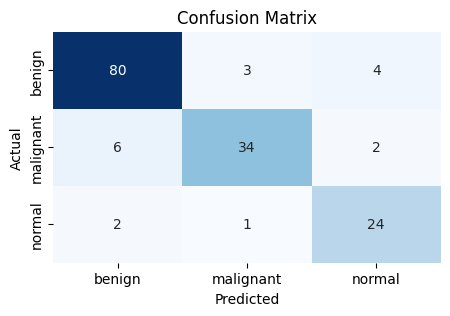

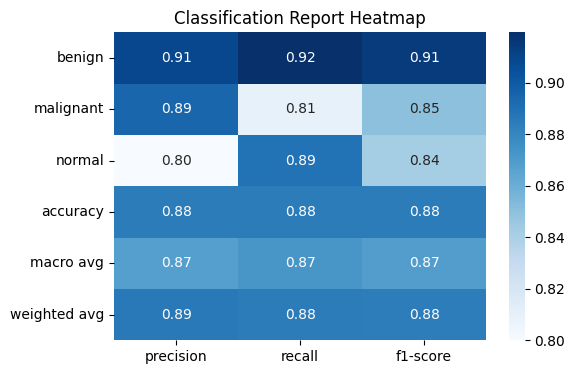

Simplified Classification Report:
             benign  malignant    normal  accuracy  macro avg  weighted avg
precision  0.909091   0.894737  0.800000  0.884615   0.867943      0.886345
recall     0.919540   0.809524  0.888889  0.884615   0.872651      0.884615
f1-score   0.914286   0.850000  0.842105  0.884615   0.868797      0.884485


In [21]:
# Define label names
label_names = [str(class_names[i]) for i in range(len(class_names))]

# Calculate classification report and confusion matrix on unseen test data
y_true = []
y_pred = []

model_fineTuning.eval()  # Set model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_fineTuning(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Generate classification report
classification_rep = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)

# Generate confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with label names
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Convert the classification report to a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(classification_rep).iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')  # Simplify classification report
plt.title('Classification Report Heatmap')
plt.show()

# Print the simplified classification report
print("Simplified Classification Report:")
print(pd.DataFrame(classification_rep).iloc[:-1, :])  # Display without support and avg/total rows


## Approach 1 - Visualizing results on few samples- Actual vs Prediction

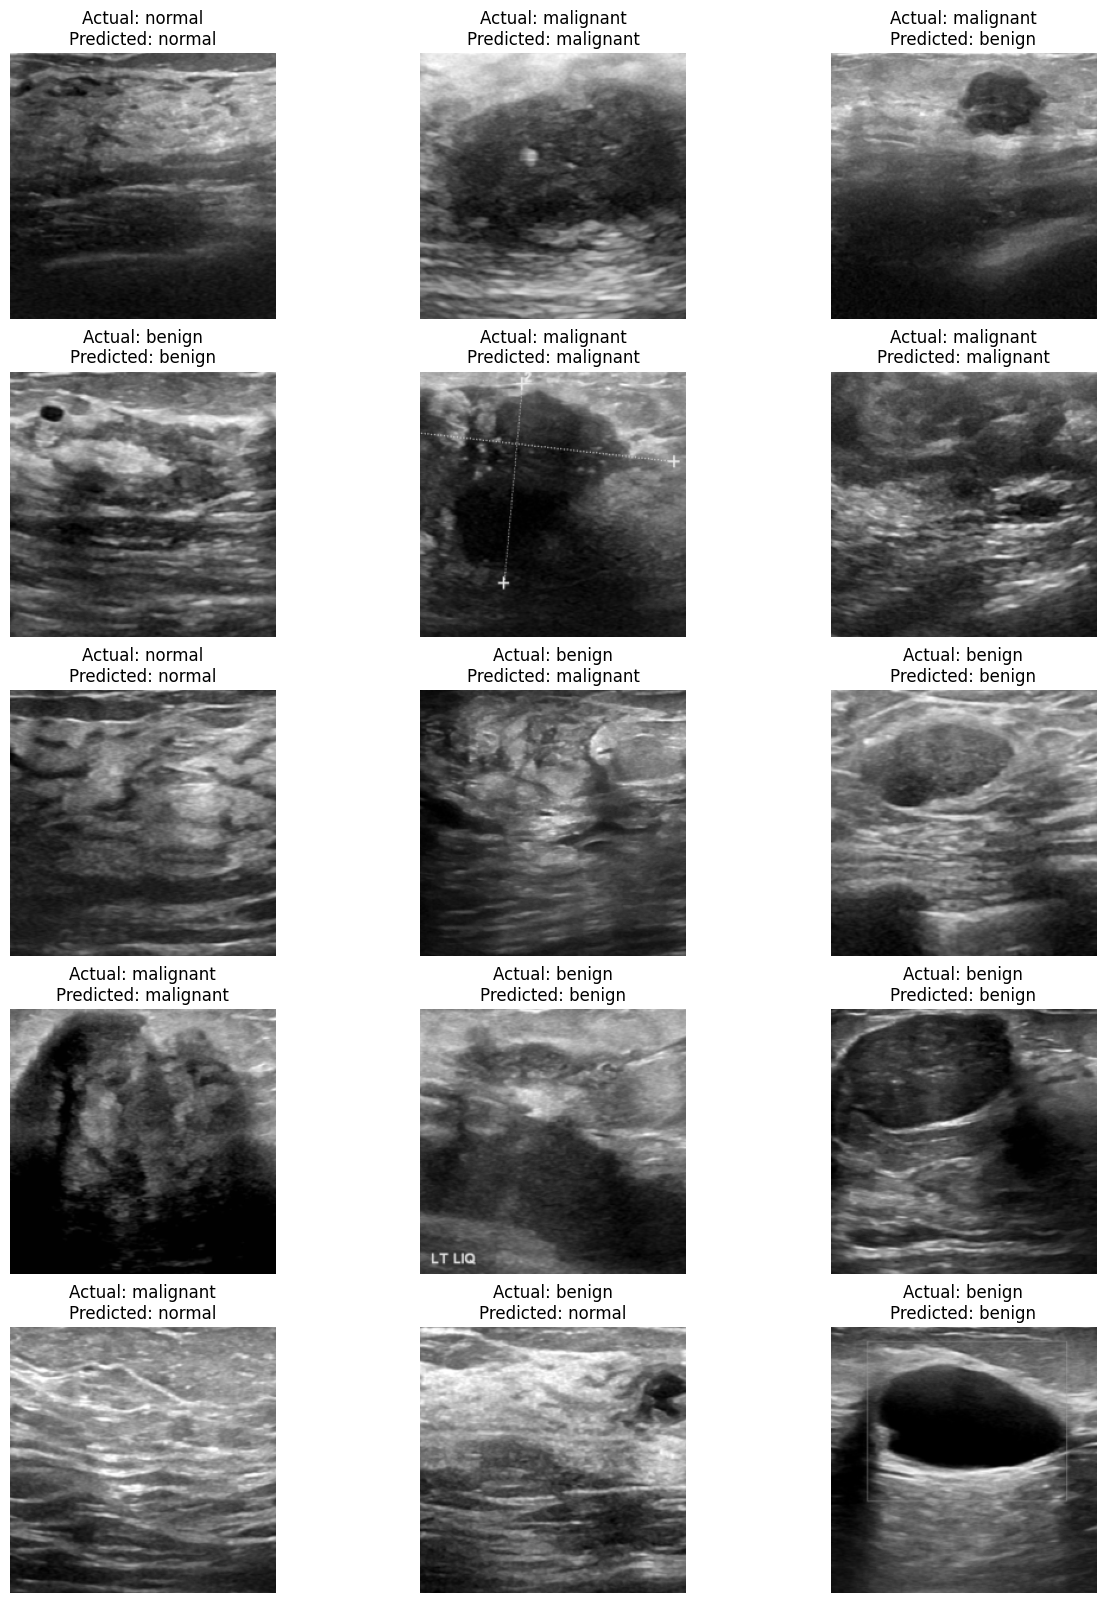

In [22]:
# Set the number of images to display
num_images_to_display = 15

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(image_datasets['test'], batch_size=num_images_to_display, shuffle=True, num_workers=4)

# Get a batch of test data
inputs, labels = next(iter(test_dataloader))

# Move inputs to the device
inputs = inputs.to(device)

# Convert images to grayscale
grayscale_images = inputs.cpu().numpy().mean(axis=1)  # Convert RGB to grayscale

# Get model predictions
with torch.no_grad():
    model_fineTuning.eval()
    outputs = model_fineTuning(inputs)
    _, preds = torch.max(outputs, 1)

# Plot the grayscale images with labels and predictions
plt.figure(figsize=(15, 20))  # Increase the height to accommodate 5 rows
for i in range(num_images_to_display):
    ax = plt.subplot(5, 3, i + 1)  # Adjust the layout to 5 rows by 3 columns
    ax.axis('off')
    ax.set_title(f'Actual: {class_names[labels[i]]}\nPredicted: {class_names[preds[i]]}')
    plt.imshow(grayscale_images[i], cmap='gray')  # Display the grayscale image

plt.show()
